## U-net + ResNet50

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [1]:
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train.zip
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train_masks.zip
!unzip -oq /kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip

In [3]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img


In [4]:
df = pd.read_csv('/content/drive/MyDrive/input/train//train_masks.csv')
df.shape

(5088, 2)

In [5]:
val_size = 0.2
val_split = int(val_size * df.shape[0])

train_df = df[:-val_split]
val_df = df[-val_split:]

train_df.shape, val_df.shape

((4071, 2), (1017, 2))

In [6]:
train_df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [7]:
img_name, mask_rle = train_df.iloc[0]

img = cv2.imread(f'/content/drive/MyDrive/input/train/./train/{img_name}')
mask = rle_decode(mask_rle)

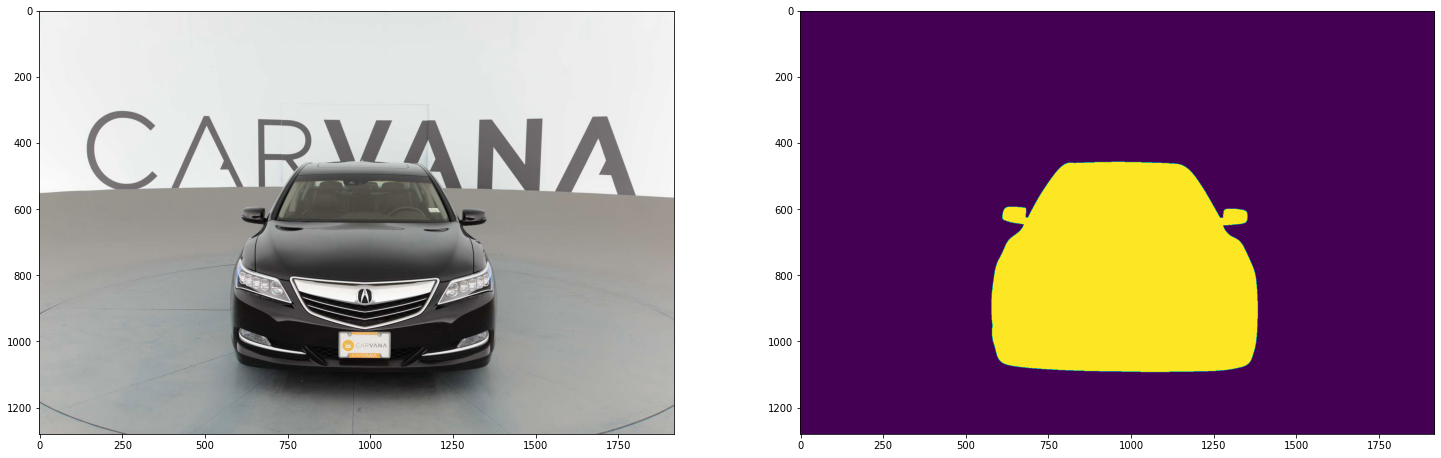

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(img)
ax[1].imshow(mask)

plt.show()

In [9]:
train_df.sample(1)

,img,rle_mask
1384,3d7a1030deeb_09.jpg,480408 2 482325 3 484243 4 486161 4 488079 4 4...


In [10]:
def keras_generator(df, batch_size, preprocess_input=None):
    while True:
        X_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = df.sample(1).values[0]
            img = cv2.imread(f'/content/drive/MyDrive/input/train//train/{img_name}')
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            X_batch += [img]
            y_batch += [mask]

        if preprocess_input:
            X_batch = preprocess_input(np.array(X_batch))
        else:
            X_batch = np.array(X_batch) / 255.0
            
        y_batch = np.array(y_batch, dtype='float')

        yield X_batch, y_batch

In [11]:
for X, y in keras_generator(val_df, batch_size=32):
    print(X.shape, y.shape)
    break

(32, 256, 256, 3) (32, 256, 256)


In [12]:
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K
base_model = ResNet50(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
base_out = base_model.output
base_out

94773248/94765736 [==============================] - 1s 0us/step


<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [13]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
conv1 = base_model.get_layer('conv1_relu').output  # (128, 128, 64)
conv2 = base_model.get_layer('conv2_block1_out').output  # (64, 64, 256)
conv3 = base_model.get_layer('conv3_block1_1_relu').output  # (32, 32, 128)
conv4 = base_model.get_layer('conv4_block2_2_relu').output  # (16, 16, 256)
conv5 = base_model.get_layer('conv5_block1_2_relu').output  # (8, 8, 512)

In [15]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
print(conc_1)
conv_conc_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(conc_1)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 768), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [16]:
up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(up5)

In [17]:
unet_50 = Model(inputs=base_model.input, outputs=conv_conc_5)
unet_50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
checkpoint_best = keras.callbacks.ModelCheckpoint('unet_50_best.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=True,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)

checkpoint_last = keras.callbacks.ModelCheckpoint('unet_50_last.h5',
                                                  monitor='val_loss',
                                                  verbose=0,
                                                  save_best_only=False,
                                                  save_weights_only=False,
                                                  mode='auto',
                                                  period=1)


callbacks = [checkpoint_best, checkpoint_last]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

unet_50.compile(adam, 'binary_crossentropy')

In [19]:
batch_size = 16

unet_50.fit(keras_generator(train_df, batch_size, preprocess_input),
            steps_per_epoch=100,
            epochs=3, verbose=1,
            callbacks=callbacks,
            validation_data=keras_generator(val_df, batch_size, preprocess_input),
            validation_steps=10)

Epoch 1/3
100/100 [==============================] - 66s 578ms/step - loss: 0.1821 - val_loss: 0.0258
Epoch 2/3
100/100 [==============================] - 56s 566ms/step - loss: 0.0221 - val_loss: 0.0211
Epoch 3/3
100/100 [==============================] - 56s 566ms/step - loss: 0.0172 - val_loss: 0.0171


In [20]:
unet_50.evaluate(keras_generator(val_df, batch_size, preprocess_input), steps=25)

25/25 [==============================] - 11s 458ms/step - loss: 0.0168


0.016829650849103928

In [21]:
for X, y in keras_generator(val_df, 16, preprocess_input):
    #plt.imshow(X[0])
    #print(X[0].min(), X[0].max())
    break

In [22]:
pred = unet_50.predict(X)

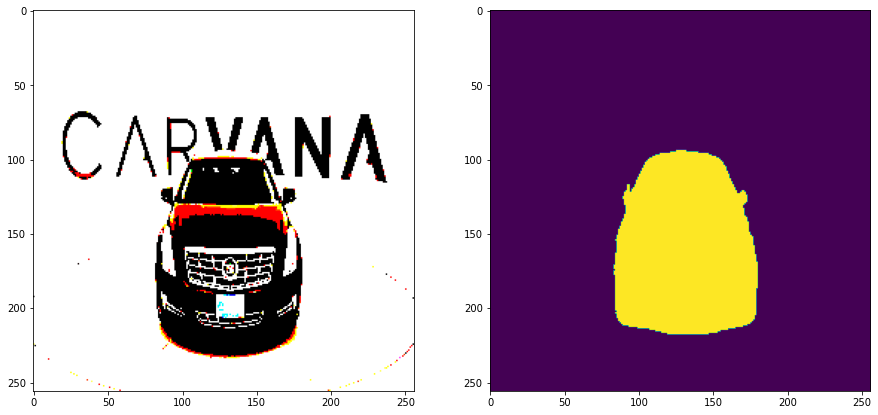

In [23]:
idx = 0
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(X[idx])
axes[1].imshow(pred[idx, ..., 0] > 0.5)

plt.show()